In [108]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [109]:
from fastai.vision import *
from torch import nn
from collections import defaultdict
from torch.utils.data import SequentialSampler
from fastai3D import mysampler
import configparser
#from fastai3D import functions
#from fastai3D import loader #does not comply 

# Configure and Filter data

In [110]:
config = configparser.ConfigParser()
config.read('train_3D_oat.ini')

['train_3D_oat.ini']

In [111]:
path = Path(config['data']['dir'])
path.ls()

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/NewLabels'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_3D_big_rot.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/3D_pretrain_rot.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/3D_pretrain.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/3D_pretrain_rot2.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Images'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/3D_pretrain_rot_f.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Test'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/models'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_big.pkl'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/LabelsPredicted'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/train/Oat_test/Oat_3D_b

In [112]:
#path = Path('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train') #suze_device
#path = Path('/home/suze/seed_images/Data_for_ML_Test//test_model/Barley_test')
#path.ls()

In [113]:
#path_img = path/'Images' #should later be provided through ini file
#path_lbl = path/'Labels' #should later be provided through ini file #suze_device
#path_lbl = path/'NewLabels' #should later be provided through ini file

In [114]:
path_img = path/config['data']['images']
path_lbl = path/config['data']['labels']
valid = config['data']['valid']
classes = int(config['data']['classes'])
model_in = config['data']['pretrain']
model_name = config['data']['model']

Uncomment in case of file issues

In [115]:
#img_names=get_image_files(path_img)
#img_names[:3]
#lbl_names=get_image_files(path_lbl)
#lbl_names[:3]

uncomment for error testing

In [117]:
#mask = open_mask(get_mask(img_names[0]))
#mask.show()
#img = open_image(img_names[0])
#img.show()

In [118]:
#src_size = np.array(mask.shape[1:])
#src_size,mask.data

In [119]:
def get_mask(img):
    return (path_lbl)/img.name

def filter_background(img_list):
    include=[]
    for img in img_list:
        mask = open_mask(get_mask(img))
        count_total=(torch.unique(mask.data, return_counts=True))
        if not count_total[0].tolist() == [0]:
            include.append(img)
    return include

"""function to filter out images that only contain background; used to filter in the API; 
function has to return a boolean
slow, every mask has to be opened to check the values"""
def check_back(img):
    mask = open_mask(get_mask(img))
    count_total=(torch.unique(mask.data, return_counts=True))
    if not count_total[0].tolist() == [0]:
        return True
    else:
        return False

def count_mask(img_list):
    img_list = filter_background(img_list)
    count_classes = defaultdict(int)
    for img in img_list:
        #return the occurence of every class in the mask for an image
        mask = open_mask(get_mask(img))
        count_total = torch.unique(mask.data, return_counts=True)
        classes=count_total[0].tolist()
        count_real=count_total[1].tolist()
        for x, y in zip(classes, count_real):
            count_classes[x] += y
    return count_classes

def img_train(path_img, valid):
    #create a list of images not in validation set
    path = path_img.parent
    valid_names = loadtxt_str(path/valid)
    img_names = get_image_files(path_img)
    train_img = list(filter(lambda x: (x.name not in valid_names), img_names))
    return train_img

def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0 #not interested in background
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

### Calculate appropriate weights


In [120]:
train_img = img_train(path_img, valid)

In [121]:
#%time classes_count = count_mask(train_img)
#classes_count
#slow for big sets, make faster?
#classes_count = defaultdict(int, {0: 2257029582, 1: 1081204683, 2: 118606496, 3: 68549863}) #only original view
classes_count = defaultdict(int, {0: 6594921884, 1: 3243614049, 2: 355819488, 3: 205649589}) #rotation set inlcuded

Check to make sure all classes are represented in the training set.

In [122]:
if len(classes_count.items()) != classes: print('Not all classes present in training data.')

In [123]:
#append classes in a list 
counts = []
for c in classes_count:
    counts.append(classes_count[c])
counts
#counts = [2257029582, 1081204683, 118606496, 68549863]

[6594921884, 3243614049, 355819488, 205649589]

In [124]:
weight_ratios =[min(counts)/x for x in counts]
weight_ratios
#weight_ratios = [0.030371716678722734, 0.06340137448331788, 0.5779604432458741, 1.0]

[0.031183021211961332, 0.06340137448331788, 0.5779604432458741, 1.0]

# Data Loading
Load in data and apply transformations etc

In [125]:
#Configure settings for training
bs = int(config['training_settings']['batch_size'])
wd = float(config['training_settings']['wd'])
lr = float(config['training_settings']['lr'])
size_s = int(config['training_settings']['size_s'])
size_m = int(config['training_settings']['size_m'])
size_l = int(config['training_settings']['size_l'])
epochs_s1 = int(config['training_settings']['epochs_s1'])
epochs_s2 = int(config['training_settings']['epochs_s2'])
epochs_m = int(config['training_settings']['epochs_m'])
epochs_l = int(config['training_settings']['epochs_l'])

In [126]:
src = (SegmentationItemList.from_folder(path, presort=True)
       .filter_by_folder(include=config['data']['images'])
       .filter_by_func(check_back)
       .split_by_fname_file(valid)
       .label_from_func(get_mask, classes=list(range(classes))))

In [128]:
data = (src.transform(tfm_y=True,
        size=size_l)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

### Change to custom sampler for order within batches

In [129]:
from fastai3D import loader
data.train_dl = data.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data.train_dl), bs, True))

In [130]:
data

ImageDataBunch;

Train: LabelList (6169 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Valid: LabelList (2608 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Test: None

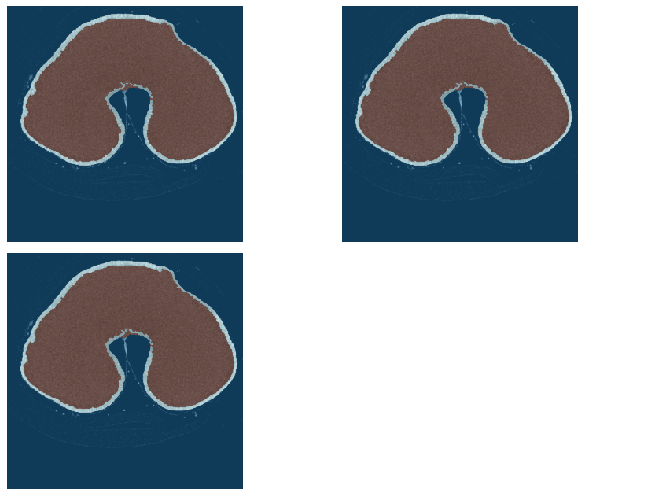

In [132]:
data.show_batch(4, figsize=(10,7))

# Create learner

In [134]:
metrics=acc_seeds

In [135]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
load_learner(path, file=model_in)

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Valid: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kern

In [136]:
#set class weights
class_weights=torch.FloatTensor(weight_ratios)
learn.crit = nn.CrossEntropyLoss(weight=class_weights.cuda())

In [137]:
#learn.lr_find()
#learn.recorder.plot()

## Add 3D layers to learner

In [138]:
def conv3_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               is_2d:bool = False, trans_2d:bool = False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose3d if transpose else nn.Conv1d if is_1d else nn.ConvTranspose2d if trans_2d else nn.Conv2d if is_2d else nn.Conv3d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d if is_2d else nn.BatchNorm3d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

def stack_1(x):
    return torch.stack(tuple(x), dim = 3)

def stack_2(x):
    return torch.unsqueeze(x,0)

stack_layers = nn.Sequential(
    Lambda(stack_1),
    Lambda(stack_2)
)


def unstack_1(x):
    return torch.squeeze(x, dim = 0)

def unstack_2(x):
    return torch.stack(torch.unbind(x, dim = 3), dim =0)

unstack_layers = nn.Sequential(
    Lambda(unstack_1),
    Lambda(unstack_2)
)

just3D = nn.Sequential(conv3_layer(4,64),conv3_layer(64,4))

mini3DUnet = SequentialEx(conv3_layer(4, 64),
                          conv3_layer(64,128),
                          conv3_layer(128,64),
                         conv3_layer(64,4),
                         MergeLayer())

midi3DUnet = SequentialEx(conv3_layer(4,64),
                          SequentialEx(conv3_layer(64,128),
                                       (SequentialEx(conv3_layer(128,128), MergeLayer())),
                                      conv3_layer(128,64), MergeLayer()),
                         conv3_layer(64,4),
                         MergeLayer())

#midi3DUnet = nn.Sequential(conv3_layer(4,64),
#                                        SequentialEx(nn.MaxPool3d(kernel_size=3, stride=2),
#                                                    conv3_layer(64,128),
#                                                     
#                                                    SequentialEx(nn.MaxPool3d(kernel_size=3, stride=2),
#                                                                conv3_layer(128,128),
#                                                                 MergeLayer()),
#                                                     
#                                                     MergeLayer(),
#                                                    conv3_layer(128,64)),
#                          conv3_layer(64,64),
#                          nn.Conv3d(64,4, kernel_size=3))

In [139]:
learn.model.append(stack_layers.cuda())
learn.model.append(midi3DUnet.cuda())
learn.model.append(unstack_layers.cuda())

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [140]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
ReLU                 [64, 75, 75]         0          False     
__________________________________________________

In [141]:
#learn.freeze()
learn.freeze_to(13)

In [142]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
ReLU                 [64, 75, 75]         0          False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


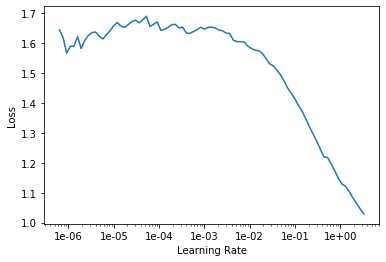

In [143]:
learn.lr_find()
learn.recorder.plot()

# Start learning

In [144]:
lr = 3e-2
lrs = slice(lr/100,lr)

In [145]:
learn.fit_one_cycle(cyc_len=1, max_lr=lrs)
#learn.fit_one_cycle(cyc_len=epochs_s1, max_lr=lrs)

epoch,train_loss,valid_loss,acc_seeds,time
0,0.106742,0.282673,0.761429,04:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


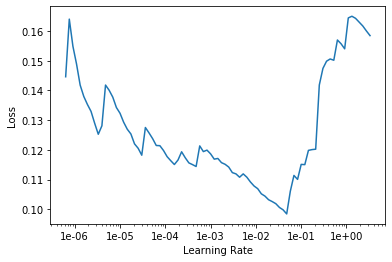

In [147]:
learn.lr_find()
learn.recorder.plot()

In [148]:
lr = 1e-6
lrs = slice(lr/100,lr)

In [149]:
learn.fit_one_cycle(cyc_len=1, max_lr=lrs)

epoch,train_loss,valid_loss,acc_seeds,time
0,0.096756,0.329285,0.723529,04:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


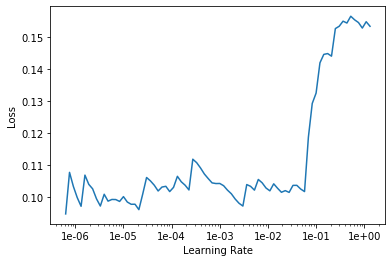

In [150]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(cyc_len=2, max_lr=lrs)

In [151]:
learn.export(model_name)
#learn.export('3D_pretrain_f.pkl')

# Training Interpretations on Validation Set

In [152]:
from fastai.vision.interpret import *
interp = SegmentationInterpretation.from_learner(learn)

In [153]:
top_losses, top_idxs = interp.top_losses(sizes=(size_l,size_l))
top_idxs

tensor([2287, 2290, 2289,  ..., 2605, 2606, 2607])

In [154]:
learn.validate(data.valid_dl)

[0.32928512, tensor(0.7235)]

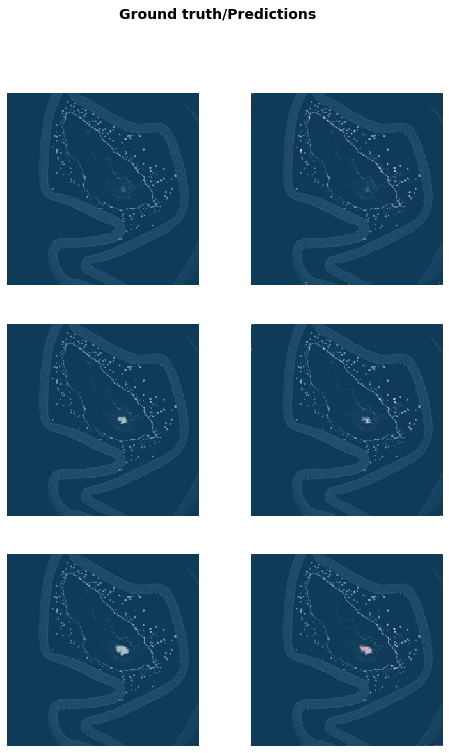

In [155]:
learn.show_results()

In [156]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
0.0,0.995158
1.0,0.843332
2.0,0.477179
3.0,0.000022


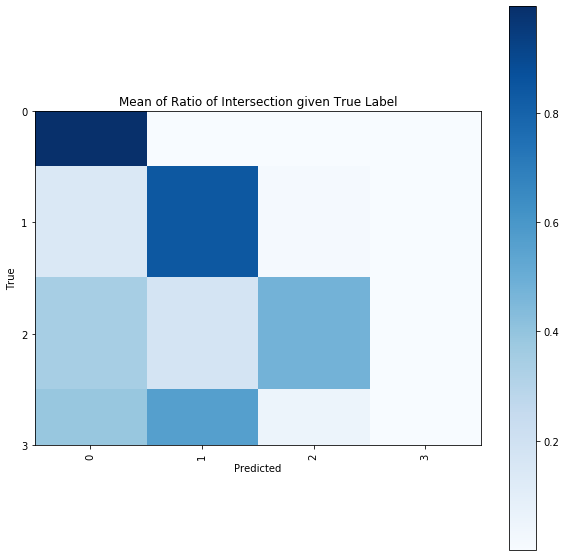

In [157]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

label,score
0.0,0.998839
2.0,0.397761
1.0,0.291948
3.0,0.000000


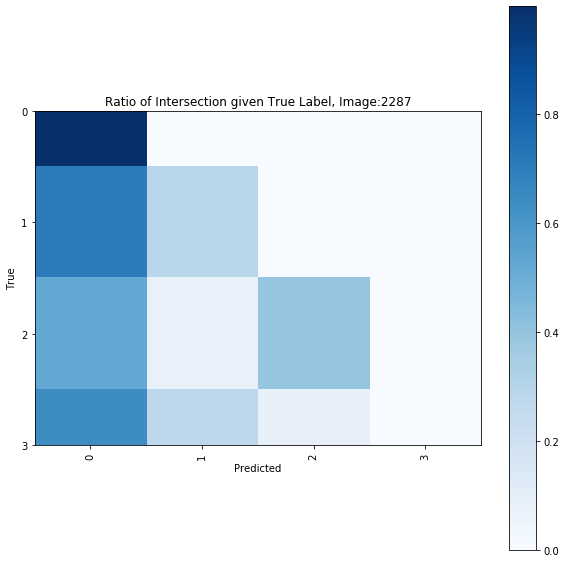

In [158]:
# Look at single worst performing picture
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [159]:
def _interp_show_new(self, ims:ImageSegment, classes:Collection=None, sz:int=20, cmap='tab20',
                    title_suffix:str=None):
        "Show ImageSegment with color mapping labels"
        fig,axes=plt.subplots(1,2,figsize=(sz,sz))
        np_im = to_np(ims.data).copy()
        # tab20 - qualitative colormaps support max of 20 distinc colors
        # if len(classes) > 20 close idxs map to same color
        # image
        if classes is not None:
            class_idxs = [self.c2i[c] for c in classes]
            mask = np.max(np.stack([np_im==i for i in class_idxs]),axis=0)
            np_im = (np_im*mask).astype(np.float)
            np_im[np.where(mask==0)] = np.nan
        im=axes[0].imshow(np_im[0], cmap=cmap)

        # labels
        np_im_labels = list(np.unique(np_im[~np.isnan(np_im)]))
        c = len(np_im_labels); n = math.ceil(np.sqrt(c))
        label_im = np.array(np_im_labels + [np.nan]*(n**2-c)).reshape(n,n)
        axes[1].imshow(label_im, cmap=cmap)
        for i,l in enumerate([self.i2c[l] for l in np_im_labels]):
            div,mod=divmod(i,n)
            #l = "\n".join(wrap(l,10)) if len(l) > 10 else l #bug fix
            axes[1].text(mod, div, f"{l}", ha='center', color='white', fontdict={'size':sz})

        if title_suffix:
            axes[0].set_title(f"{title_suffix}_imsegment")
            axes[1].set_title(f"{title_suffix}_labels")
            
import types
def show_xyz_new(self, i, classes:list=None, sz=10):
        'show (image, true and pred) from self.ds with color mappings, optionally only plot'
        funcType = types.MethodType
        self._interp_show = funcType(_interp_show_new, self)
        x,y = self.ds[i]
        self.ds.show_xys([x],[y], figsize=(sz/2,sz/2))
        self._interp_show(ImageSegment(self.y_true[i]), classes, sz=sz, title_suffix='true')
        self._interp_show(ImageSegment(self.pred_class[i][None,:]), classes, sz=sz, title_suffix='pred')

In [ ]:
funcType = types.MethodType
interp.show_xyz = funcType(show_xyz_new, interp)
interp.show_xyz(i)

# Evalution of Test Data

In [202]:
from PIL import Image
from fastai.vision.interpret import *

In [203]:
#provide config file name through cmd line
config = configparser.ConfigParser()
config.read('pred_3D_oat.ini')

['pred_3D_oat.ini']

In [204]:
path = Path(config['data']['dir_to_model'])
model = (config['data']['model'])

In [206]:
lsiList = (SegmentationItemList.from_folder(path, presort=True)
       .split_by_folder(train='Images', valid='Test')
       .label_from_func(get_mask, classes=list(range(classes))))

In [207]:
data_test = (lsiList.transform( 
        tfm_y=True, 
        size=300)
        .databunch(bs=3)
        .normalize(imagenet_stats))

In [208]:
#from fastai3D import loader
data_test.train_dl = data_test.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data_test.train_dl), 3, True))

In [209]:
learn.data.valid_dl = data_test.valid_dl

In [210]:
data_test

ImageDataBunch;

Train: LabelList (9045 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Valid: LabelList (2316 items)
x: SegmentationItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/suze/seed_images/Data_for_ML_Test/train/Oat_test;

Test: None

In [212]:
#learn.validate(data_test.valid_dl)

In [213]:
# Interpret
interp = SegmentationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

In [214]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
0.0,0.994348
1.0,0.582612
2.0,0.543544
3.0,0.000041


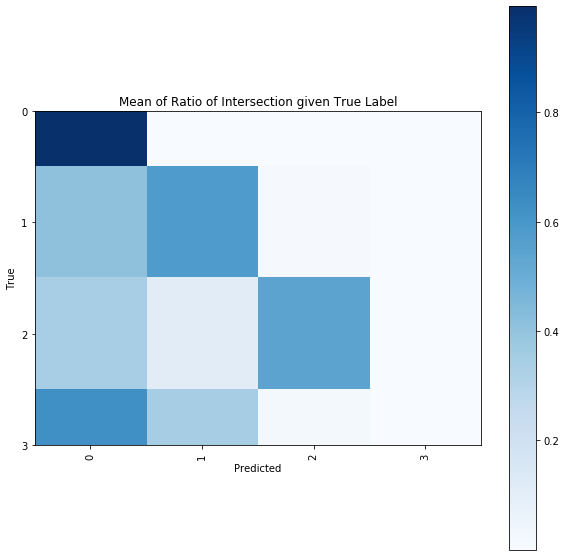

In [215]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
funcType = types.MethodType
interp.show_xyz = funcType(show_xyz_new, interp)
interp.show_xyz(1600)